In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
file_name_dataset = "CREMAD"
dataset_cremad_dir = "../Dataset/CREMAD/AudioWAV"
crema_dir_list = os.listdir(dataset_cremad_dir)
print(len(crema_dir_list))

7442


In [3]:
emotion_dict = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fear",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

female_ids = [
    1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1012, 1013, 1018, 1020,
    1021, 1024, 1025, 1028, 1029, 1030, 1037, 1043, 1046, 1047, 1049, 1052,
    1053, 1054, 1055, 1056, 1058, 1060, 1061, 1063, 1072, 1073, 1074, 1075,
    1076, 1078, 1079, 1082, 1084, 1089, 1091
]

In [4]:
# gender_list = []
# emotion_list = []
# path_list = []

# for audio_file in crema_dir_list:
#     part = audio_file.split('_')
#     speaker_id = int(part[0])
#     emotion_segment = part[2]

#     if speaker_id in female_ids:
#         gender = 'female'
#     else:
#         gender = 'male'
#     gender_list.append(gender)
    
#     if emotion_segment in emotion_dict:
#         emotion = f"{gender}_{emotion_dict[emotion_segment]}"
#     else:
#         emotion = "unknown"
#     emotion_list.append(emotion)

#     # Construct full path
#     audio_file_path = os.path.join(dataset_cremad_dir, audio_file)
#     path_list.append(audio_file_path)

# cremad_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
# cremad_df.to_csv("crema_gender_divided_df.csv", index = False)
# cremad_df.head()

In [5]:
emotion_list = []
path_list = []

for audio_file in crema_dir_list:
    emotion_segment = audio_file.split("_")[2]

    audio_file_path = os.path.join(dataset_cremad_dir, audio_file);

    path_list.append(audio_file_path)
    
    if emotion_segment in emotion_dict:
        emotion_list.append(emotion_dict[emotion_segment])
    else:
        emotion_list.append("unknown")

cremad_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
cremad_df.to_csv("crema_df.csv", index = False)
cremad_df.head()

,Emotion,Path
0,angry,../Dataset/CREMAD/AudioWAV\1001_DFA_ANG_XX.wav
1,disgust,../Dataset/CREMAD/AudioWAV\1001_DFA_DIS_XX.wav
2,fear,../Dataset/CREMAD/AudioWAV\1001_DFA_FEA_XX.wav
3,happy,../Dataset/CREMAD/AudioWAV\1001_DFA_HAP_XX.wav
4,neutral,../Dataset/CREMAD/AudioWAV\1001_DFA_NEU_XX.wav


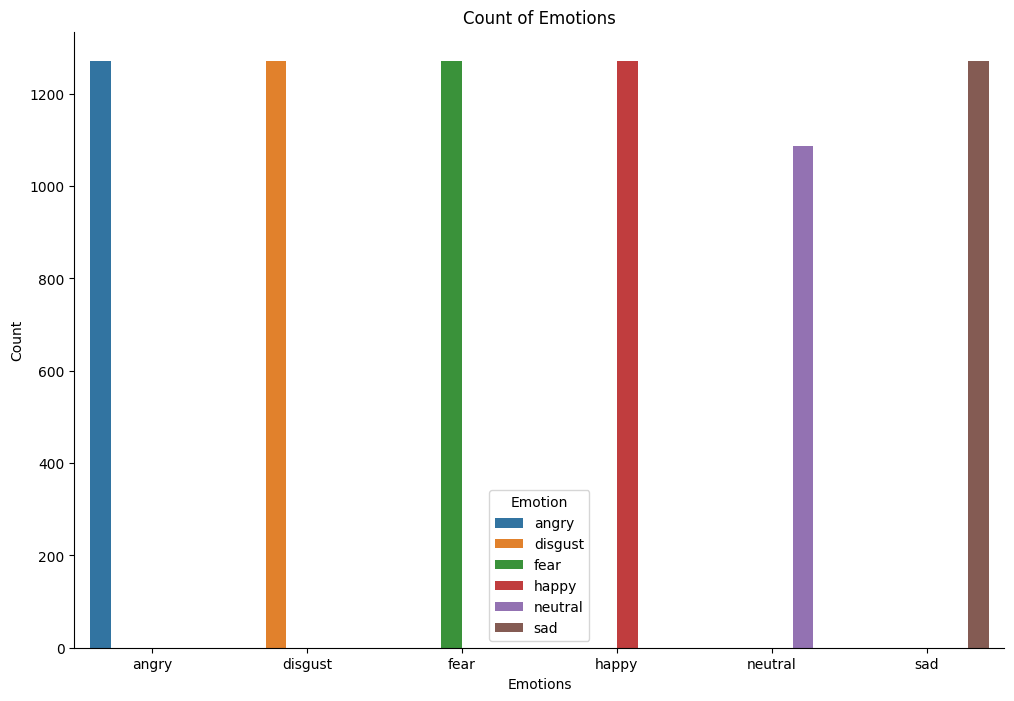

In [6]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = cremad_df.Emotion, hue = cremad_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [7]:
def waveplot(data, sr, emo):
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, emo):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

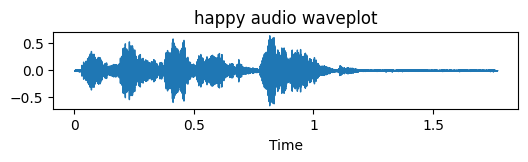

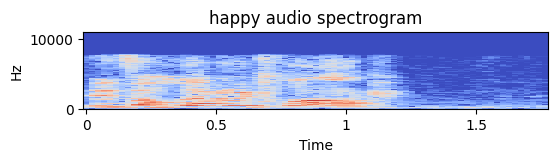

In [8]:
emotion = 'happy'

audio_file_path = np.array(cremad_df.Path[cremad_df.Emotion.str.contains(emotion)])[1]
data, sampling_rate = librosa.load(audio_file_path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(audio_file_path)

In [9]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [10]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

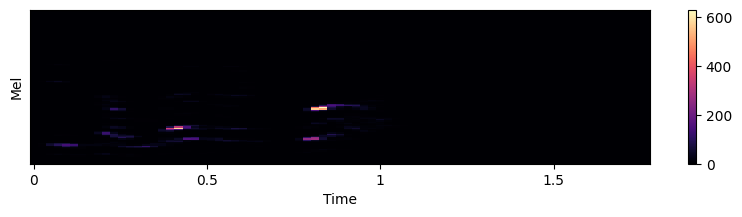

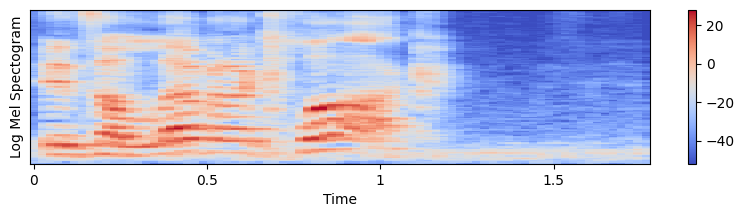

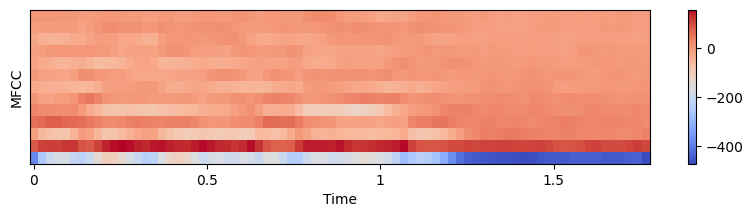

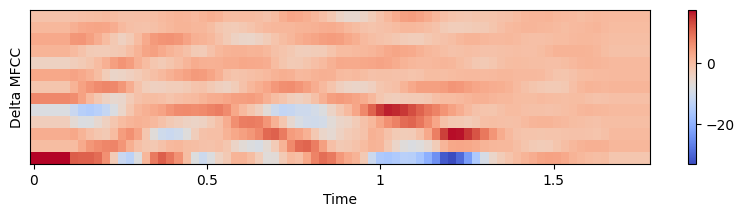

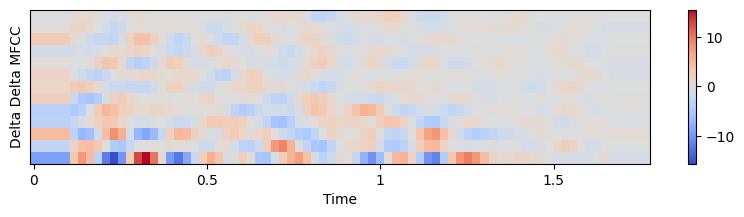

In [11]:
mel = extract_mel(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mel, x_axis='time', sr = sampling_rate)
plt.ylabel('Mel')
plt.colorbar()

log_mel_spec = extract_log_mel_spec(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(log_mel_spec, x_axis='time', sr = sampling_rate)
plt.ylabel('Log Mel Spectogram')
plt.colorbar()

# MFCC
mfcc = extract_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('MFCC')
plt.colorbar()

# ΔMFCC
delta_mfcc = extract_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta MFCC')
plt.colorbar()

# ΔΔMFCC
delta_delta_mfcc = extract_delta_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta Delta MFCC')
plt.colorbar()
plt.show()

# MFCC-based approximate entropy
# MFCC-based spectral entropy
# Three-dimensional Mel-scale frequency cepstral coefficients

In [12]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_mfcc = extract_delta_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=0)
    delta_delta_mfcc_mean = np.mean(delta_delta_mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [13]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [14]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [15]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(cremad_df)

df.head()

100%|██████████| 7442/7442 [32:42<00:00,  3.79it/s] 


,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,angry,-324.209656,128.394699,-19.360773,45.353886,-7.781060,16.801313,-25.136724,-2.042650,-12.736442,...,-1.864211,-2.119521,-0.189407,-4.199693,-3.302313,-7.454986,-2.417529,-5.826252,-1.815566,-3.811474
1,angry,-196.762771,44.706110,4.429743,13.129668,7.330029,-1.711826,-8.556963,-9.797507,-5.595860,...,-1.705363,-1.143840,-1.074367,-2.159876,-3.694179,-4.251210,-3.241302,-3.173163,-3.132594,-2.073959
2,angry,-352.322266,122.154366,-16.779375,42.125114,-4.254804,14.272593,-23.693497,-3.985848,-11.508269,...,-1.509214,-1.809634,-0.149823,-3.671370,-3.347424,-7.655435,-3.534138,-6.595549,-2.471215,-3.998390
3,angry,-349.410889,123.933052,-19.841911,42.932838,-6.837504,14.142020,-25.004187,-2.957357,-11.775821,...,-2.424353,-2.644801,-0.980734,-4.018171,-3.084413,-7.916318,-3.277132,-6.774976,-2.997807,-4.538830
4,angry,-349.312866,117.321793,-15.838222,41.113838,-6.893109,10.765023,-25.524975,-2.207326,-12.541373,...,-3.170501,-0.418629,-4.489011,-5.964576,-6.101850,-5.328276,-5.286351,-4.557995,-0.976714,-1.787351


In [16]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [17]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35721, 40), (35721, 6), (8931, 40), (8931, 6))

In [19]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35721, 40), (35721, 6), (8931, 40), (8931, 6))

In [20]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35721, 40, 1), (35721, 6), (8931, 40, 1), (8931, 6))

In [21]:
def create_model(model_type, epochs):
    model = Sequential()
    
    if model_type == 'GRU':
        model.add(GRU(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(128))
    elif model_type == 'LSTM':
        model.add(LSTM(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Bidirectional(GRU(128)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(128)))
    elif model_type == 'CNN':
        model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(256, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
    else:
        raise ValueError("Invalid RNN model. Choose from 'GRU', 'LSTM', 'BiGRU', 'BiLSTM', or 'CNN'.")

    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=3, min_lr=0.00001)
    checkpoint = ModelCheckpoint(model_type + " # " + filename + ' # Epoch 20.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop, checkpoint])

    model.save(model_type + ' # Epoch 20.h5')    
    
    return model, history

In [22]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [23]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [24]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [25]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    prediction_actual_df.head()

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [26]:
model_lstm, history_lstm = create_model("LSTM", 20)
model_gru, history_gru = create_model("GRU", 20)
model_bilstm, history_bilstm = create_model("BiLSTM", 20)
model_bigru, history_bigru = create_model("BiGRU", 20)
model_cnn, history_cnn = create_model("CNN", 20)

Epoch 1/20
558/559 [============================>.] - ETA: 0s - loss: 1.5352 - accuracy: 0.3533
Epoch 1: val_accuracy improved from -inf to 0.36480, saving model to LSTM # CREMAD # MFCC Mean 40 # Noise 0.04 & Low Speed 0.75 & High Speed 1.25 & Pitch Shift 0.7 & Shift (-5, 5) # Epoch 20.h5
559/559 [==============================] - 42s 64ms/step - loss: 1.5352 - accuracy: 0.3533 - val_loss: 1.5197 - val_accuracy: 0.3648 - lr: 0.0010
Epoch 2/20
559/559 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.3958
Epoch 2: val_accuracy improved from 0.36480 to 0.38316, saving model to LSTM # CREMAD # MFCC Mean 40 # Noise 0.04 & Low Speed 0.75 & High Speed 1.25 & Pitch Shift 0.7 & Shift (-5, 5) # Epoch 20.h5
559/559 [==============================] - 28s 51ms/step - loss: 1.4622 - accuracy: 0.3958 - val_loss: 1.4753 - val_accuracy: 0.3832 - lr: 0.0010
Epoch 3/20
559/559 [==============================] - ETA: 0s - loss: 1.4255 - accuracy: 0.4144
Epoch 3: val_accuracy improve

280/280 [==============================] - 2s 6ms/step - loss: 0.8217 - accuracy: 0.7555
Test Loss: 0.821655809879303
Test Accuracy: 0.7554585337638855


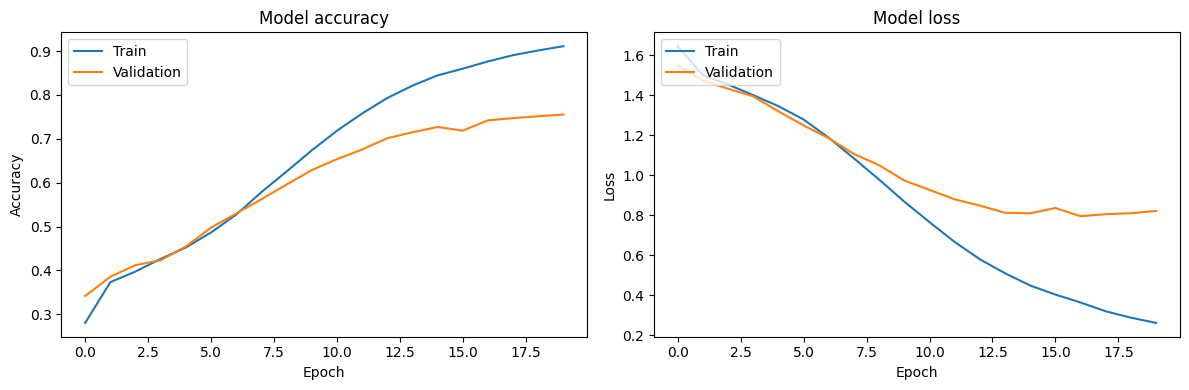

In [27]:
evaluate_model(model_gru)
plot_history(history_gru)

280/280 [==============================] - 5s 14ms/step


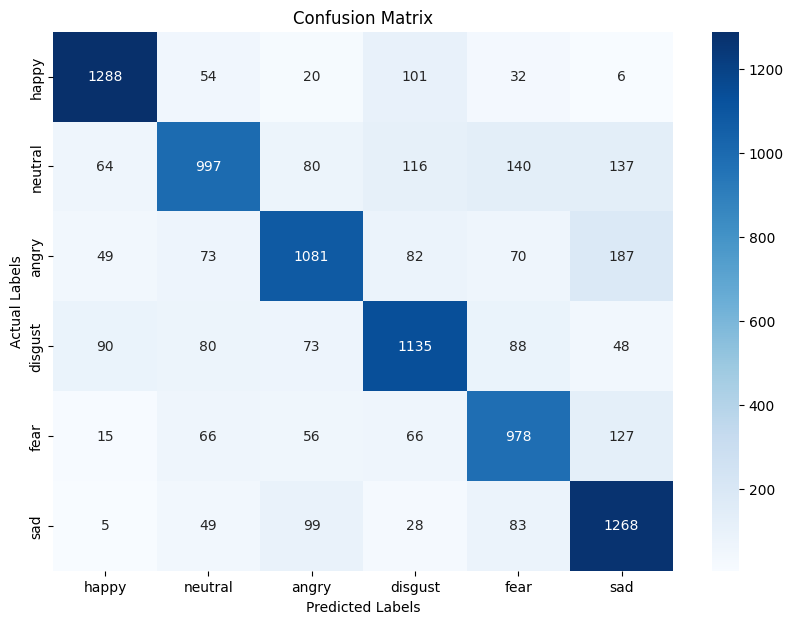

              precision    recall  f1-score   support

       angry       0.85      0.86      0.86      1501
     disgust       0.76      0.65      0.70      1534
        fear       0.77      0.70      0.73      1542
       happy       0.74      0.75      0.75      1514
     neutral       0.70      0.75      0.72      1308
         sad       0.72      0.83      0.77      1532

    accuracy                           0.76      8931
   macro avg       0.76      0.76      0.75      8931
weighted avg       0.76      0.76      0.75      8931

Accuracy: 75.55%


In [28]:
create_model_summary(model_gru)

280/280 [==============================] - 3s 9ms/step - loss: 0.7630 - accuracy: 0.7418
Test Loss: 0.7630079388618469
Test Accuracy: 0.7417982220649719


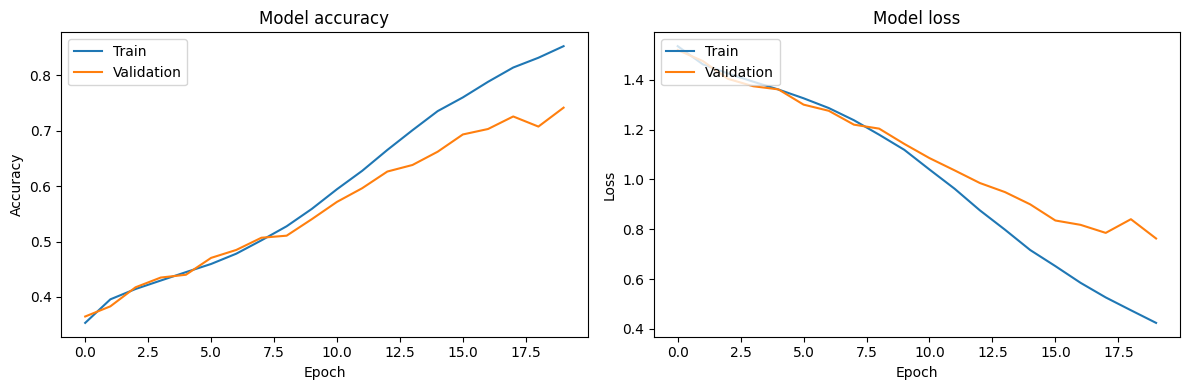

In [29]:
evaluate_model(model_lstm)
plot_history(history_lstm)

280/280 [==============================] - 6s 15ms/step


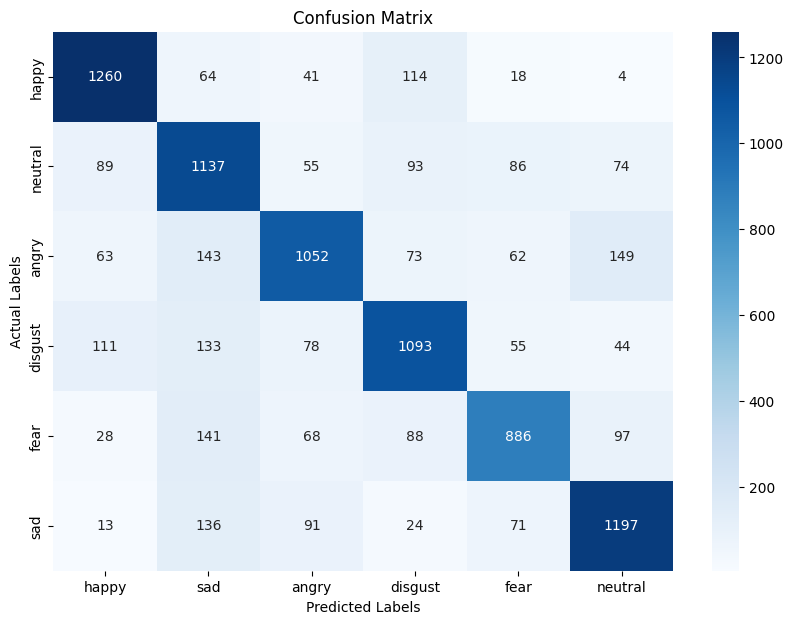

              precision    recall  f1-score   support

       angry       0.81      0.84      0.82      1501
     disgust       0.65      0.74      0.69      1534
        fear       0.76      0.68      0.72      1542
       happy       0.74      0.72      0.73      1514
     neutral       0.75      0.68      0.71      1308
         sad       0.76      0.78      0.77      1532

    accuracy                           0.74      8931
   macro avg       0.74      0.74      0.74      8931
weighted avg       0.74      0.74      0.74      8931

Accuracy: 74.18%


In [30]:
create_model_summary(model_lstm)

280/280 [==============================] - 8s 29ms/step - loss: 0.7131 - accuracy: 0.8094
Test Loss: 0.7131146192550659
Test Accuracy: 0.8094278573989868


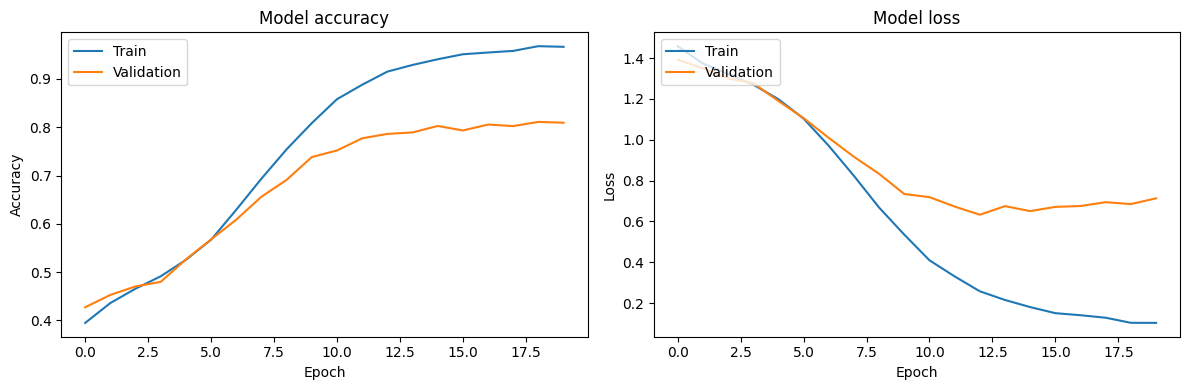

In [31]:
evaluate_model(model_bilstm)
plot_history(history_bilstm)

280/280 [==============================] - 10s 30ms/step


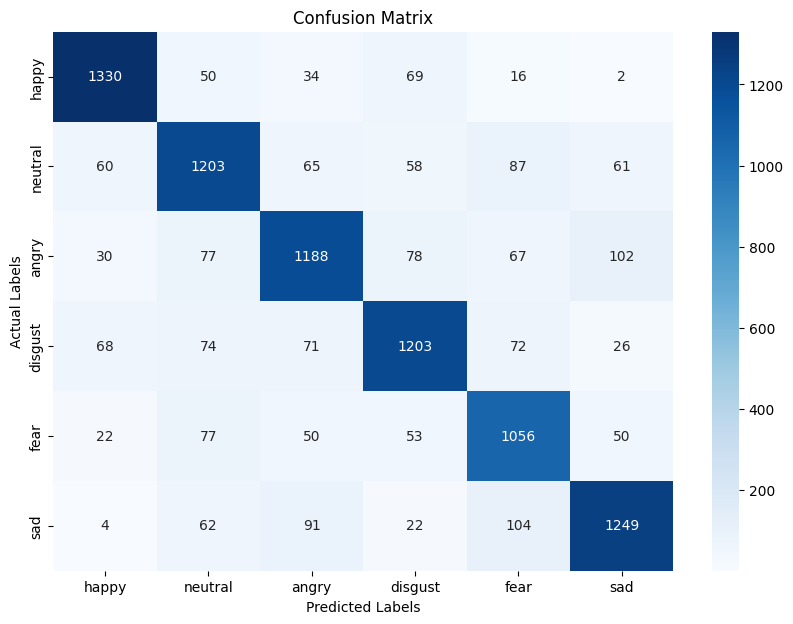

              precision    recall  f1-score   support

       angry       0.88      0.89      0.88      1501
     disgust       0.78      0.78      0.78      1534
        fear       0.79      0.77      0.78      1542
       happy       0.81      0.79      0.80      1514
     neutral       0.75      0.81      0.78      1308
         sad       0.84      0.82      0.83      1532

    accuracy                           0.81      8931
   macro avg       0.81      0.81      0.81      8931
weighted avg       0.81      0.81      0.81      8931

Accuracy: 80.94%


In [32]:
create_model_summary(model_bilstm)

280/280 [==============================] - 3s 12ms/step - loss: 0.8869 - accuracy: 0.7795
Test Loss: 0.8868541121482849
Test Accuracy: 0.7795319557189941


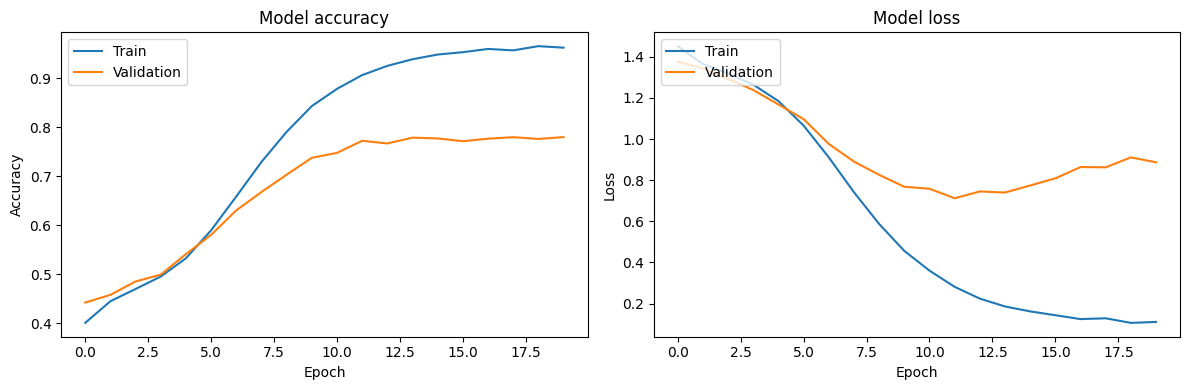

In [33]:
evaluate_model(model_bigru)
plot_history(history_bigru)

280/280 [==============================] - 7s 11ms/step


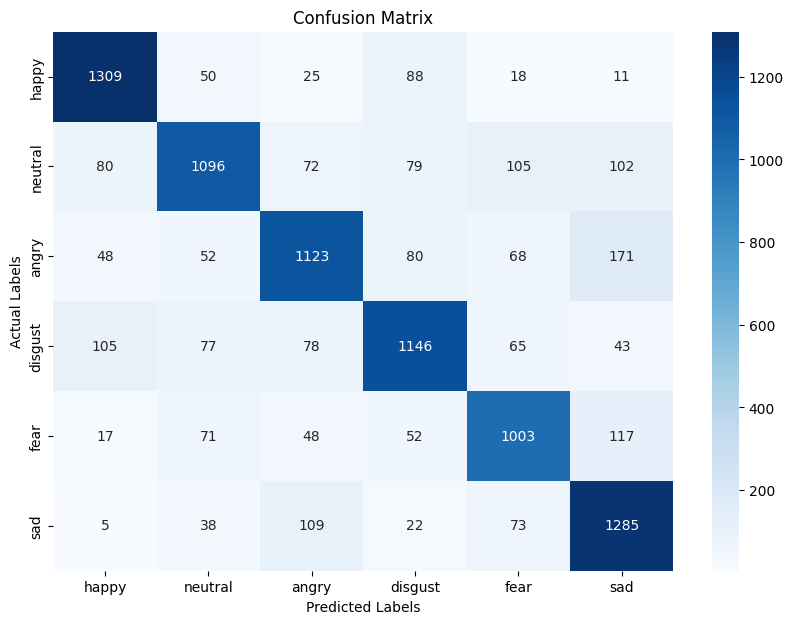

              precision    recall  f1-score   support

       angry       0.84      0.87      0.85      1501
     disgust       0.79      0.71      0.75      1534
        fear       0.77      0.73      0.75      1542
       happy       0.78      0.76      0.77      1514
     neutral       0.75      0.77      0.76      1308
         sad       0.74      0.84      0.79      1532

    accuracy                           0.78      8931
   macro avg       0.78      0.78      0.78      8931
weighted avg       0.78      0.78      0.78      8931

Accuracy: 77.95%


In [34]:
create_model_summary(model_bigru)

280/280 [==============================] - 1s 3ms/step - loss: 1.1290 - accuracy: 0.7643
Test Loss: 1.1289563179016113
Test Accuracy: 0.7643041014671326


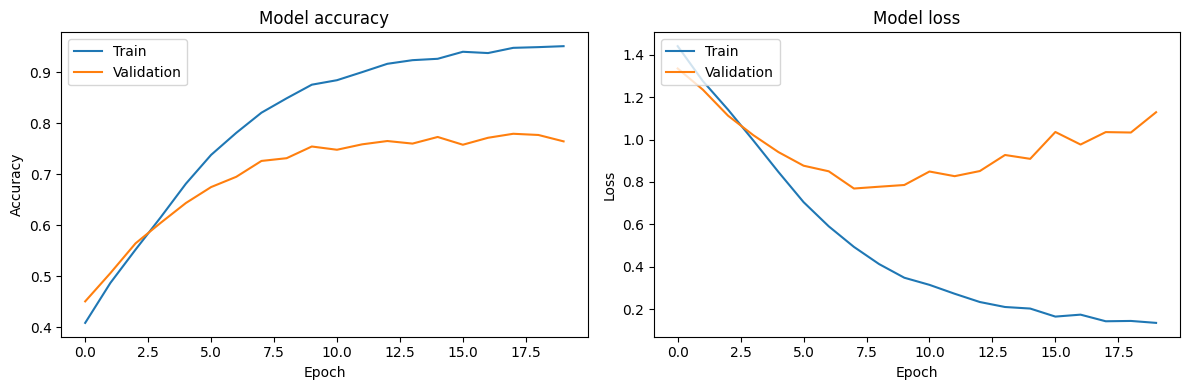

In [35]:
evaluate_model(model_cnn)
plot_history(history_cnn)

280/280 [==============================] - 1s 2ms/step


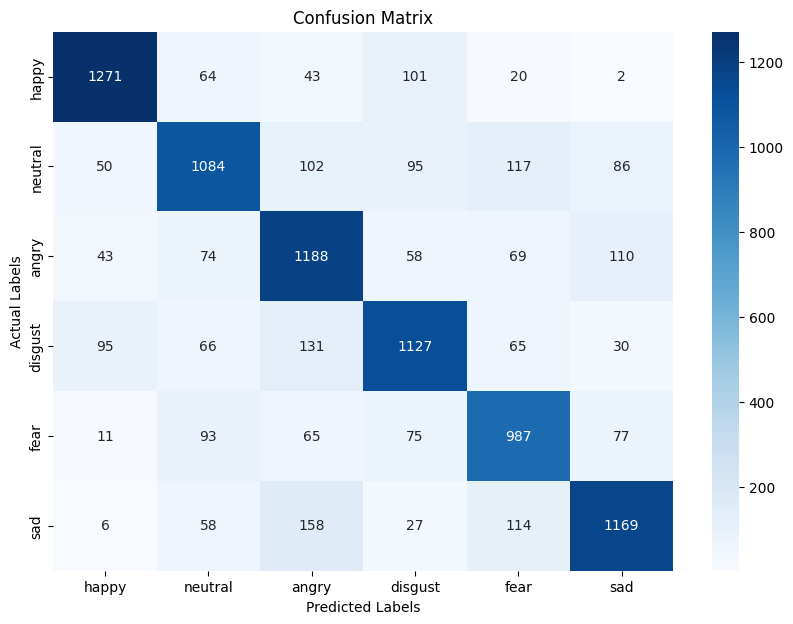

              precision    recall  f1-score   support

       angry       0.86      0.85      0.85      1501
     disgust       0.75      0.71      0.73      1534
        fear       0.70      0.77      0.74      1542
       happy       0.76      0.74      0.75      1514
     neutral       0.72      0.75      0.74      1308
         sad       0.79      0.76      0.78      1532

    accuracy                           0.76      8931
   macro avg       0.77      0.76      0.76      8931
weighted avg       0.77      0.76      0.76      8931

Accuracy: 76.43%


In [36]:
create_model_summary(model_cnn)